This notebook provides an example of how to fit a simple reinforcement learning model to a dataset. For an excellent guide to how to fit reinforcement learning models to data, please have a look at http://www.princeton.edu/~ndaw/d10.pdf

In [26]:
# set up imports
import numpy
import statsmodels.nonparametric.smoothers_lowess
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline

First, we need to generate some data.

In [2]:
# softmax response function
def softmax(q,temp):
        p=numpy.exp(q[0]/temp)/(numpy.exp(q[0]/temp)+numpy.exp(q[1]/temp))
        if p>numpy.random.rand():
            return 0
        else:
            return 1
        
# function to generate probabilistic outcomes
# p_A is probability of reward for outcome 1
def outcome(resp,correct,prob=0.75):
    if numpy.random.rand()<prob:
        rewarded_outcome=correct
    else:
        rewarded_outcome=numpy.abs(1-correct)
    if resp==rewarded_outcome:
        return 1
    else:
        return 0
 
# function to generate correct responses
def get_correct_resp(ntrials=1000,nswitch=50):
    correct_resp=numpy.zeros(ntrials)
    # switch every 50 trials
    for i in range(0,ntrials,nswitch*2):
        correct_resp[i:(i+nswitch)]=1
    return correct_resp



In [14]:
# forward model to generate data using q-learning
def generate_data(learning_rate=0.1,temp=1,prob=0.8):

    correct_resp=get_correct_resp()
    ntrials=len(correct_resp)
    q=numpy.zeros((ntrials,2))
    resp=numpy.zeros(ntrials)
    reward=numpy.zeros(ntrials)
    
    for i in range(ntrials):
        if i==0:
            q[i,:]=numpy.array([0,0])
        else:
            q[i,:]=q[i-1,:]
        resp[i]=softmax(q[i,:],temp)
        reward[i]=outcome(resp[i],correct_resp[i],prob)
        q[i,int(resp[i])]=q[i,int(resp[i])] + learning_rate*(reward[i]-q[i,int(resp[i])])

    return resp,reward,q,learning_rate,temp

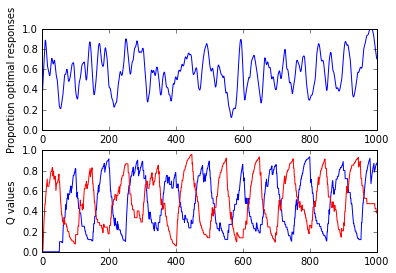

In [15]:
# generate some data and plot it

resp,reward,q,learning_rate,temp=generate_data(prob=0.9)
correct= resp==get_correct_resp()

plt.subplot(2,1,1)
smooth=statsmodels.nonparametric.smoothers_lowess.lowess(correct,numpy.arange(resp.shape[0]),frac=0.02)
plt.plot(smooth[:,1])
plt.axis([0,1000,0,1])
plt.xlabel('trials')
plt.ylabel('Proportion optimal responses')
plt.subplot(2,1,2)
plt.plot(q[:,0],'blue')
plt.plot(q[:,1],'red')
plt.ylabel('Q values')

Now, we want to fit a model to the behavior above.  It is challenging to estimate both the learning rate and temperature parameters, so we will just fix temperature and estimate learning rate.  We first need to implement the likelihood function for the Q-learning model.

In [8]:
# we will be using a minimization routine, so we return the negative log likelihood
def q_negloglike(params):
    lr=params[0]
    if len(params)>1:
        temp_t=params[1]
    else:
        temp_t=1
        
    assert resp.shape[0]==reward.shape[0]
    
    q=[0.0,0,0]
    ll_sum=0
    
    for i in range(resp.shape[0]):
        # log of choice probability (from Daw): β · Qt(ct) − log(exp(β · Qt(L)) + exp(β · Qt(R)))
        ll_sum+=temp_t*q[int(resp[i])] - numpy.log(numpy.exp(q[0]*temp_t)+numpy.exp(q[1]*temp_t))
        q[int(resp[i])]=q[int(resp[i])] + lr*(reward[i]-q[int(resp[i])])
    return -1*ll_sum
        

Fit the likelihood function to the data by maximum likelihood for a range of parameter values, and plot the likelihood surface.

In [9]:
lrvals=numpy.arange(0,1,0.005)
tempvals=numpy.arange(0,2,0.01)
ll=numpy.zeros((len(lrvals),len(tempvals)))
for lr in range(len(lrvals)):
  for t in range(len(tempvals)):
    ll[lr,t]=q_negloglike([lrvals[lr],tempvals[t]])

parameter values (estimated/true):
learning rate: 0.070/0.100
temperature: 1.120/1.000


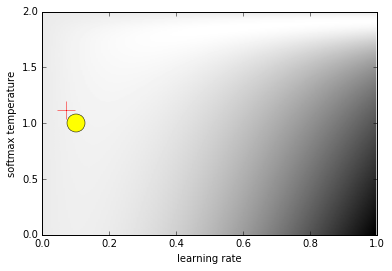

In [19]:
plt.imshow(-1*ll,aspect='auto',cmap='gray',
           extent=[numpy.min(lrvals),numpy.max(lrvals),numpy.min(tempvals),numpy.max(tempvals)])
plt.xlabel('learning rate')
plt.ylabel('softmax temperature')
plt.plot(learning_rate,temp,marker='o',markersize=18,color='yellow')
maxloc=numpy.where(ll==numpy.min(ll))
plt.plot(lrvals[maxloc[0][0]],tempvals[maxloc[1][0]],marker='+',markersize=18,color='red')
#plt.plot(loglike[80,:10])
print('parameter values (estimated/true):')
print('learning rate: %0.3f/%0.3f'%(lrvals[maxloc[0][0]],learning_rate))
print('temperature: %0.3f/%0.3f'%(tempvals[maxloc[1][0]],temp))

In [11]:
# function to perform maximum likelihood estimation 

def ml_est(start=None):
    if not start:
        start=[1e-3]
    result=minimize(q_negloglike,start,bounds=[[0,1]])
    if result['success']:
        return result['x']
    else:
        return [numpy.nan]

Let's generate a bunch of datasets and look at how well the model fits.  for each model, compute estimates using multiple starting points (randomly chosen within the allowable range of parameter values)

In [12]:
nruns=100
est=numpy.zeros(nruns)
lrate=numpy.zeros(nruns)

for r in range(nruns):
    lrate[r]=numpy.random.rand()*0.2 + 0.05
    resp,reward,_,_,_=generate_data(learning_rate=lrate[r],temp=1.0)
    mle=ml_est()
    if numpy.isnan(mle[0]):
        nanctr+=1
    est[r]=mle

   

0.8458336240242561

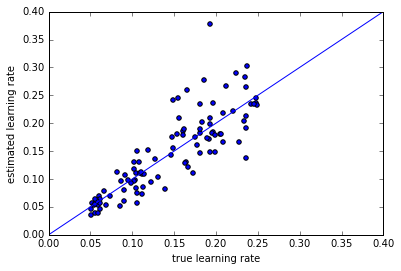

In [25]:
plt.scatter(lrate,est)
plt.xlabel('true learning rate')
plt.ylabel('estimated learning rate')
plt.axis([0,0.4,0,0.4])
plt.plot([0,0.4],[0,0.4])
numpy.corrcoef(lrate,est)[0,1]